In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/캡스톤/거시경제및커피가격통합데이터.csv")

In [ ]:
we = pd.read_csv("/content/drive/MyDrive/캡스톤/기후데이터피쳐선택.csv")

In [ ]:
 we.drop(columns=['Coffee_Price'], inplace=True)

In [ ]:
df = pd.merge(df, we, on='Date', how='left')

In [ ]:
df = df.dropna()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
train_size = int(len(df) * 0.8)
train_df, test_df = df.loc[:df.index[train_size-1]], df.loc[df.index[train_size:]]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_seq = MinMaxScaler()
train_df = pd.DataFrame(scaler_seq.fit_transform(train_df),
                        columns=train_df.columns,
                        index=train_df.index)

In [ ]:
## dataset: Input dataset
## target: output dataset(target for prediction)
## data_window : data window의 크기 입니다 (하나의 데이터 윈도우에 몇 개의 데이터가 들어가는지)
## target_size : 예측해야하는 레이블 입니다.
import numpy as np
import torch
from torch.utils.data import Dataset

class MultiStepTimeSeriesDataset(Dataset):
    def __init__(self, dataset, target, data_window, target_size, step, single_step=False):
        self.data, self.labels = [], []

        start_index = data_window
        end_index = len(dataset) - target_size  # 미래 예측을 고려해 끝점 조정

        for i in range(start_index, end_index):
            indices = range(i - data_window, i, step)  # X 데이터 생성 (샘플링 적용)
            self.data.append(dataset[indices])

            if single_step:
                self.labels.append(target[i + target_size])  # 단일 값 예측
            else:
                self.labels.append(target[i:i + target_size])  # 다중 스텝 예측

        # 리스트를 PyTorch Tensor로 변환
        self.data = torch.tensor(np.array(self.data), dtype=torch.float32)
        self.labels = torch.tensor(np.array(self.labels), dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
X_train = train_df.values
target_col = "Coffee_Price"
y_train = train_df[target_col].values

In [ ]:
data_window = 100  # 최근 100개 데이터를 입력으로 사용
future_target = 14  # 14개 미래 값 예측
step = 6  # 6개 단위로 샘플링
train_dataset = MultiStepTimeSeriesDataset(X_train, y_train, data_window, future_target, step)

LSTM 입력을 위해 3D 배열로 변경

In [ ]:
X_train = train_dataset.data
y_train = train_dataset.labels

In [ ]:
X_train.shape

torch.Size([1800, 17, 57])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=2, target_size=14, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.target_size = target_size

        # LSTM 계층
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

        # output_dim을 target_size로 설정 (multi-step prediction)
        self.fc = nn.Linear(hidden_size, target_size)

    def forward(self, x, hidden_states=None):
        if hidden_states is None:
            batch_size = x.shape[0]
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            hidden_states = (h0, c0)

        out, hidden_states = self.lstm(x, hidden_states)  # LSTM 실행
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 은닉 상태를 사용해 14개 예측

        return out, hidden_states  # (batch_size, target_size) 형태

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_size = X_train.shape[2]
target_size = 14
model = LSTMModel(input_size=input_size, target_size=target_size).to(device)

# 손실 함수 및 최적화 함수 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
num_epochs = 200
hidden_states = None  # 한 에폭 내에서 유지

for epoch in range(num_epochs):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        if hidden_states is None or x_batch.shape[0] != hidden_states[0].shape[1]:
            hidden_states = (
                torch.zeros(model.num_layers, x_batch.shape[0], model.hidden_size).to(device),
                torch.zeros(model.num_layers, x_batch.shape[0], model.hidden_size).to(device)
            )

        hidden_states = tuple(h.detach() for h in hidden_states)

        # 모델 예측
        y_pred, hidden_states = model(x_batch, hidden_states)

        # `y_pred`가 `(batch_size, target_size, 1)`이면 `(batch_size, target_size)`로 변환
        if y_pred.shape[-1] == 1:
            y_pred = y_pred.squeeze(-1)

        # Loss 계산
        loss = criterion(y_pred, y_batch)

        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)  # Gradient Clipping
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/200], Loss: 0.0065
Epoch [2/200], Loss: 0.0017
Epoch [3/200], Loss: 0.0043
Epoch [4/200], Loss: 0.0023
Epoch [5/200], Loss: 0.0010
Epoch [6/200], Loss: 0.0017
Epoch [7/200], Loss: 0.0019
Epoch [8/200], Loss: 0.0015
Epoch [9/200], Loss: 0.0017
Epoch [10/200], Loss: 0.0015
Epoch [11/200], Loss: 0.0018
Epoch [12/200], Loss: 0.0027
Epoch [13/200], Loss: 0.0020
Epoch [14/200], Loss: 0.0019
Epoch [15/200], Loss: 0.0014
Epoch [16/200], Loss: 0.0006
Epoch [17/200], Loss: 0.0016
Epoch [18/200], Loss: 0.0021
Epoch [19/200], Loss: 0.0006
Epoch [20/200], Loss: 0.0007
Epoch [21/200], Loss: 0.0007
Epoch [22/200], Loss: 0.0014
Epoch [23/200], Loss: 0.0010
Epoch [24/200], Loss: 0.0013
Epoch [25/200], Loss: 0.0023
Epoch [26/200], Loss: 0.0013
Epoch [27/200], Loss: 0.0014
Epoch [28/200], Loss: 0.0030
Epoch [29/200], Loss: 0.0006
Epoch [30/200], Loss: 0.0013
Epoch [31/200], Loss: 0.0006
Epoch [32/200], Loss: 0.0007
Epoch [33/200], Loss: 0.0014
Epoch [34/200], Loss: 0.0006
Epoch [35/200], Loss: 0

예측 실행

In [ ]:
# 1. train_df 마지막 날짜의 위치를 df 전체에서 찾음
last_train_idx = df.index.get_loc(train_df.index[-1])

# 2. 그 다음 14일치 날짜를 df에서 추출
prediction_dates = df.index[last_train_idx + 1 : last_train_idx + 1 + 14]

# 3. 실제값 가져오기
true_values = df.loc[prediction_dates, 'Coffee_Price'].values

In [ ]:
true_values

array([212.8999939 , 225.80000305, 228.19999695, 218.6000061 ,
       218.69999695, 215.8500061 , 215.8500061 , 215.75      ,
       213.6499939 , 217.05000305, 226.6000061 , 229.44999695,
       229.44999695, 229.44999695])

In [ ]:
# 마지막 시퀀스 예측
last_seq = X_train[-1].unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    prediction, _ = model(last_seq)

# CPU로 이동 후 numpy 변환
prediction = prediction.squeeze().cpu().numpy().reshape(-1, 1)

# 역변환을 위해 dummy 피처 생성
dummy = np.zeros((14, train_df.shape[1] - 1))  # Coffee_Price 제외 나머지
prediction_combined = np.concatenate([prediction, dummy], axis=1)

# Coffee_Price가 첫 번째 컬럼이라면 그대로 [:, 0]
# (다른 위치일 경우 target_index로 변경 가능)
prediction = scaler_seq.inverse_transform(prediction_combined)[:, 0]

# 결과 확인
prediction

array([217.55922788, 217.63568698, 217.96053834, 217.59315398,
       217.41084341, 215.84282305, 214.75104737, 215.16123081,
       216.87581396, 218.17336706, 218.41979438, 217.74118026,
       218.1557132 , 220.08579618])

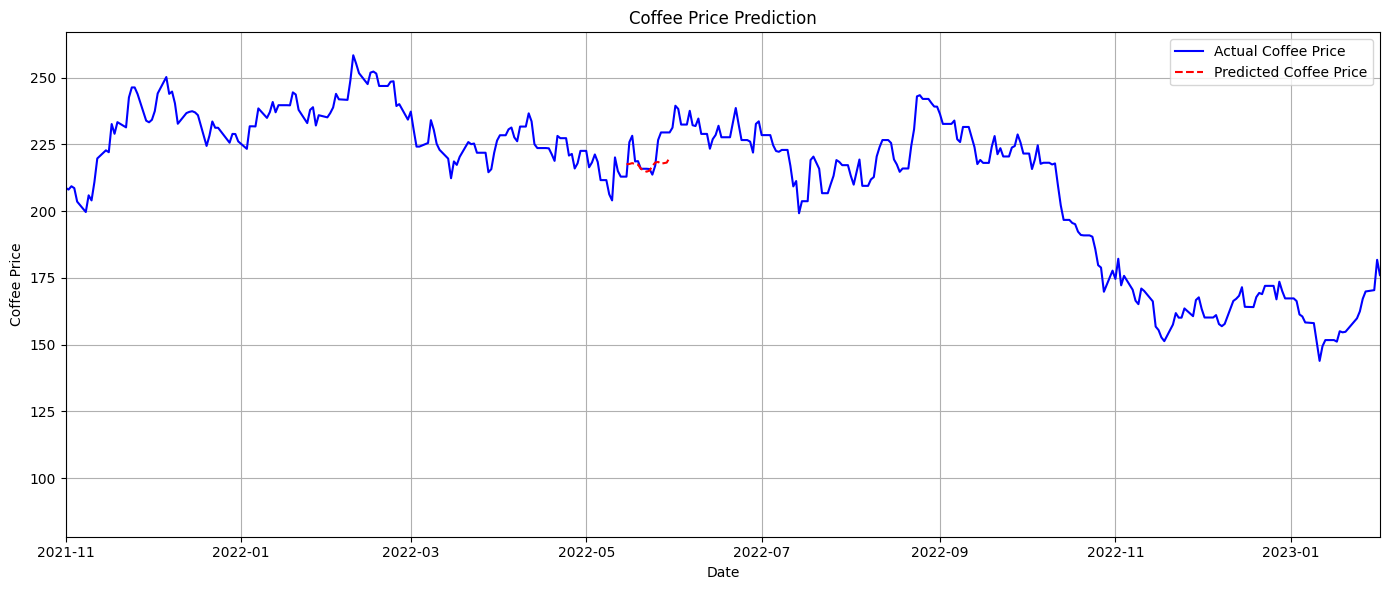

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. train_df 마지막 날짜의 위치를 df 전체에서 찾음
last_train_idx = df.index.get_loc(train_df.index[-1])

# 2. 그 다음 14일치 날짜를 df에서 추출
prediction_dates = df.index[last_train_idx + 1 : last_train_idx + 1 + 14]

# 3. 실제값 가져오기
true_values = df.loc[prediction_dates, 'Coffee_Price'].values

# 예측값 (이미 있는 prediction 변수 활용)
forecast_series = pd.Series(prediction, index=prediction_dates)

# 전체 시계열과 예측 결과를 함께 그리기
plt.figure(figsize=(14, 6))
plt.plot(df[target_col], label='Actual Coffee Price', color='blue')
plt.plot(prediction_dates, forecast_series, label='Predicted Coffee Price', color='red', linestyle='dashed')

plt.title('Coffee Price Prediction')
plt.xlabel("Date")
plt.ylabel("Coffee Price")
plt.xlim(pd.to_datetime('2021-11-01'), pd.to_datetime('2023-02-01'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
comparison_df = pd.DataFrame({
    "날짜": forecast_series.index,
    "실제값": df.loc[forecast_series.index, "Coffee_Price"].values,
    "예측값": forecast_series.values
})

In [ ]:
comparison_df[:14]

,날짜,실제값,예측값
0,2022-05-15,212.899994,217.559228
1,2022-05-16,225.800003,217.635687
2,2022-05-17,228.199997,217.960538
3,2022-05-18,218.600006,217.593154
4,2022-05-19,218.699997,217.410843
5,2022-05-20,215.850006,215.842823
6,2022-05-22,215.850006,214.751047
7,2022-05-23,215.750000,215.161231
8,2022-05-24,213.649994,216.875814
9,2022-05-25,217.050003,218.173367


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = comparison_df["실제값"][:14]
y_pred = comparison_df["예측값"][:14]

# MAE
mae = mean_absolute_error(y_true, y_pred)

# RMSE 직접 계산
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 5.1393
RMSE: 6.6995
